<a href="https://colab.research.google.com/github/dsevero/dsevero.com/blob/master/notebooks/On_Distributed_Quantization_for_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from toolz import pipe
from collections import defaultdict
from itertools import product
from joblib import Parallel, delayed
import multiprocessing
CPU_COUNT = multiprocessing.cpu_count()

colors_hex = ['#FF0000', '#0000FF']
cm_bright = ListedColormap(colors_hex)

parallel = Parallel(n_jobs=CPU_COUNT, verbose=10)

# 1. On-the-line quantizer

## 1.1 Generate data

In [ ]:
def _data_fixture():
    X = np.array([*[[0.2*i + 0.1, 0.2*(i+1)] for i in range(1, 5)],
                  *[[0.2*i + 0.1, 0.2*(i-1)] for i in range(1, 5)]])
    y = (X[:, 0] < X[:, 1]).astype(int)    
    return X, y

def normalize(X):
    x = X - X.min(axis=0)
    return x/x.max(axis=0)

def generate_data(N, separation=.25, seed=None):
    X = np.random.RandomState(seed).normal(size=(N, 2))
    y = (X[:, 0] < X[:, 1]).astype(int)
    X[y == 1, 0] -= separation
    X[y == 1, 1] += separation
    X[y == 0, 0] += separation
    X[y == 0, 1] -= separation
    X = normalize(X)
    y = (X[:, 0] < X[:, 1]).astype(int)
    return X, y

def make_potential_boundaries(X):
    return pipe(X, np.ravel, np.unique, np.sort)

def plot(X, y, boundaries=None, **plot_kwargs):
    fig, ax = plt.subplots(**plot_kwargs)
    ax.scatter(*X.T, c=y, s=25, cmap=cm_bright)
    x = np.linspace(0, 1, 100)
    ax.fill_between(x, x, 0, alpha=0.25, color=colors_hex[0])
    ax.fill_between(x, x, 1, alpha=0.25, color=colors_hex[1])

    if boundaries is not None:
        for b in boundaries:
            ax.vlines(b, 0, 1, linestyles='dashed')
            ax.hlines(b, 0, 1, linestyles='dashed')

    return fig, ax

X, y = generate_data(1000)
plot(X, y);

## 1.2 Algorithm

In [ ]:
def _min_gap_error(X, y, si, sl=-1):
    mask = ((X > sl) & (X <= si)).all(axis=1)
    return min(((y == c) & mask).sum() for c in [0, 1])

def ontheline_quantizer(X, y, R):
    s = make_potential_boundaries(X)
    E = np.zeros((len(s), 2**R))
    A = defaultdict(lambda: defaultdict(set))
    for i, si in enumerate(s):
        E[i, 0] = _min_gap_error(X, y, si)

    for i, si in enumerate(s):
        for b in range(1, 2**R):
            if i == 0:
                E[i, b] = 0
                A[i][b] = set()
            else:
                (E[i, b],
                 l_star,
                 sl_star) = min([E[l, b-1] + _min_gap_error(X, y, si, sl), l, sl]
                                for l, sl in enumerate(s[:i]))
                A[i][b] = A[l_star][b-1].union({sl_star})

    return E, A, A[len(s)-1][2**R-1]

X, y = _data_fixture()
E, A, d = ontheline_quantizer(X, y, 1)
plot(X, y, d);

## 1.3 Sanity Checks

In [ ]:
def test_zero_boundaries():
    X, y = _data_fixture()
    plot(X, y);
    boundaries = [0.20, 0.35, 0.50, 0.75, 0.90]
    errors = [0, 0, 1, 2, 3]
    for b, e in zip(boundaries, errors):
        assert _min_gap_error(X, y, b) == e
        plt.vlines(b, 0, b, linestyles='solid')
        plt.hlines(b, 0, b, linestyles='solid')
        plt.xticks(boundaries)
        plt.yticks(boundaries, labels=[f'{e}' for e in errors])
        plt.ylabel('min errors over classes')

test_zero_boundaries()

In [ ]:
def draw_square(*edges):
    plt.vlines(edges[0], edges[0], edges[1], linestyles='solid')
    plt.vlines(edges[1], edges[0], edges[1], linestyles='dashed')
    plt.hlines(edges[0], edges[0], edges[1], linestyles='solid')
    plt.hlines(edges[1], edges[0], edges[1], linestyles='dashed')

def test_gap_boundaries():
    X, y = _data_fixture()
    plot(X, y);
    gaps = [(.35, .20), (.75, .40), (1.0, .55)]
    errors = [0, 0, 1]
    for g, e in zip(gaps, errors):
        assert _min_gap_error(X, y, *g) == e
        draw_square(*g)

test_gap_boundaries()

## 1.4 Run on separable data

In [ ]:
N = 200
seed = 0
R_space = [1, 2, 3]
sep_space = [0, 0.25, 0.5]

plt.figure(figsize=(16,10))
metrics = list()
for i, (R, separation) in enumerate(product(R_space, sep_space), 1):
    X, y = generate_data(N, separation, seed)
    E, A, boundaries = ontheline_quantizer(X, y, R)
    plt.subplot(3, 3, i)

    plt.scatter(*X.T, c=y, s=25, cmap=cm_bright)
    x = np.linspace(0, 1, 100)
    plt.fill_between(x, x, 0, alpha=0.25, color=colors_hex[0])
    plt.fill_between(x, x, 1, alpha=0.25, color=colors_hex[1])

    for b in boundaries:
        plt.vlines(b, 0, 1, linestyles='dashed')
        plt.hlines(b, 0, 1, linestyles='dashed')
    
    plt.title(f'$N={N}, R={R}, seed={seed}, sep={separation}$')

    metrics.append({'loss': E[-1][-1]/N,
                    'R': R,
                    'separation': separation})

## 1.5 Does separation make the problem easier?

In [ ]:
N = 300
seed = 0
R_space = [1, 2, 3]
sep_space = np.arange(0, 1, 0.1)

@delayed
def single_run(R, separation):
    X, y = generate_data(N, separation, seed)
    E, _, _ = ontheline_quantizer(X, y, R)
    return {'loss': E[-1][-1]/N,
             'R': R,
             'separation': separation}

metrics = parallel(single_run(R, s) for R, s in product(R_space, sep_space))

(pd
 .DataFrame(metrics)
 .round(3)
 .pivot('separation', 'R', 'loss')
 .plot(style='o--', figsize=(12,5)));

## 1.6 Boundary quantization (new, not part of the paper)

In [ ]:
from matplotlib.colors import BASE_COLORS
seed = None
X, y = generate_data(N, separation, seed)

def rotate(X, angle=np.pi/4):
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    return X.dot(R.T)

RX = rotate(X)
plot(X, y, figsize=(10, 10));
plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0, 1, 0.1))

def nearestToBoundary_quantizer(mask=None, depth=5, boundaries=[]):
    mask = np.arange(y.shape[0]) if mask is None else mask
    i = np.abs(RX[mask, 0]).argmin()
    d = X[mask][i, :]

    plt.scatter(*d, c='yellow', s=100);
    plt.vlines(d[0], 0, 1, linestyles='dashed');
    plt.hlines(d[1], 0, 1, linestyles='dashed');
    
    max_error = max(((y[mask][f(X[mask], d).all(axis=1)] != c).sum(), i, f, c)
                    for i, (c, f) in enumerate(product([0, 1], [np.greater, np.less])))

    _, _, f, c = max_error
    new_mask = mask[f(X[mask], d).all(axis=1)]
    print(depth,X[mask].shape, X[i], y[i], max_error, new_mask.shape)
    # plt.scatter(*X[new_mask].T, c=list(BASE_COLORS.keys())[-depth])
    if depth > 1:
        nearestToBoundary_quantizer(new_mask, depth-1, boundaries+[d])

nearestToBoundary_quantizer(depth=3)
E, A, boundaries = ontheline_quantizer(X, y, 2)
for b in boundaries:
    plt.vlines(b, 0, 1, 'green', linestyles='dashed')
    plt.hlines(b, 0, 1, 'green', linestyles='dashed')

## 1.7 Questions and Comments
1. On-the-line quantizer minimizes consistency error, but does it minimize risk? It's a bit odd that the quantizer is data dependent. It feels like there should be a better strategy to quantize the classification regions.

2. If we allow the nodes to accumulate samples, we can apply Shannon's source coding theorem and achieve better compression.

3. By iterating over the points nearest to the margins/boundaries, can we achieve a lower complexity class for the algorithm? This may require removing the "on-the-line" condition (see the incomplete "1.6 Boundary Quantization section")

4. What happens if a node is hijacked? What interesting attacks are possible?

5. If a single node has more than one feature, can local statistics be used to increase compression? For example, by quantizing the first PCA component.

6. Instead of distributed quantization and centralized classification, try distributed classification with centralized meta-classification (e.g. voting)

7. The number of bits per node is fixed, but features with higher entropy will require more bits to properly quantize than those with lower entropy.

# 2. Polynomial Logistic Regression

## 2.1 Generating polynomials

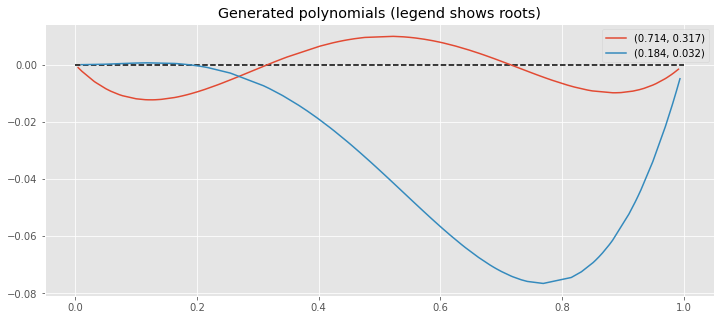

In [35]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit
plt.style.use('ggplot')

(N, d, k) = 100, 2, 2
P = np.random.uniform(0, 1, size=(d, k))
sample = np.random.uniform(0, 1, size=(N, d))

def σ(x):
    return 1/(1 + jnp.exp(-x))

def classify(probs):
    return (probs > 0.5)

def predict_probs(params, sample):
    z = poly_eval_from_roots(params, sample)
    return σ(jnp.product(z, axis=1))

def poly_eval_from_roots(P: '(dim, n_roots)', sample):
    N, d, k = sample.shape[0], *P.shape
    p = jnp.product(jnp.repeat(jnp.expand_dims(sample, -1), k, axis=-1) 
                    - jnp.repeat(jnp.expand_dims(P, 0), N, axis=0), axis=-1)
    return p*sample*(sample - 1)

z = poly_eval_from_roots(P, sample)

plt.figure(figsize=(12,5))
for i in range(d):
    idx = jnp.argsort(sample[:, i])
    roots = jnp.round(P[i], 3)
    plt.plot(sample[idx, i], z[idx, i])
plt.title('Generated polynomials (legend shows roots)')
plt.hlines(0, 0, 1, linestyles='dashed')
plt.legend([f'{tuple(roots)}' for roots in jnp.round(P, 3)]);

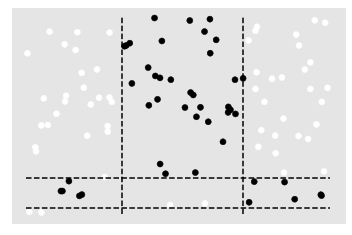

In [40]:
def predict_probs(params, sample):
    z = poly_eval_from_roots(params, sample)
    return σ(jnp.product(z, axis=1))

def plot_2d_classification(P, Q, sample):
    p = predict_probs(P, sample)
    y_true = classify(p)
    plt.vlines(Q[0], 0, 1, linestyles='dashed')
    plt.hlines(Q[1], 0, 1, linestyles='dashed')
    plt.scatter(*sample.T, c=y_true)
    plt.xticks([])
    plt.yticks([])
    plt.gray()
    
plot_2d_classification(P, P, sample)

## 2.2 Realizable case: $C \in \mathcal{H}_{k,d}$

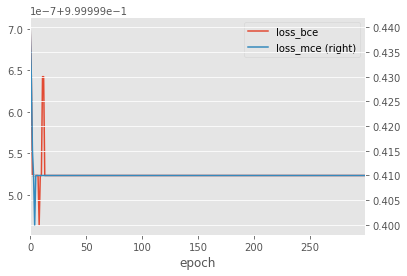

{'loss_bce': 0.9999995231628418, 'loss_mce': 0.4100000262260437, 'epoch': 299}


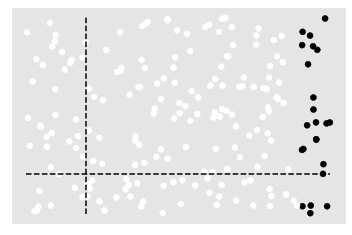

In [68]:
from jax import grad
import pandas as pd
plt.style.use('ggplot')


def binary_cross_entropy(p, q):
    return -(p*jnp.log2(q) + (1-p)*jnp.log2(1-q))

def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def loss(params, sample, p):
    q = predict_probs(params, sample)
    return jnp.min([binary_cross_entropy(p, q).mean(),
                    binary_cross_entropy(p, 1-q).mean()])

(N, d, k) = 200, 2, 1
P = np.random.uniform(0, 1, size=(d, k))
Q = np.random.uniform(0, 1, size=(d, k))
sample = np.random.uniform(0, 1, size=(N, d))
p = predict_probs(P, sample)
y_true = classify(p)
grad_loss = grad(loss)
lr = 10000

metrics = list()
for epoch in range(300):
    dQ = grad_loss(Q, sample, p)
    Q -= lr*dQ
    
    q = predict_probs(Q, sample)
    y_pred = classify(q)
    loss_mce = jnp.min([1 - accuracy(y_true, y_pred),
                        1 - accuracy(y_true, 1-y_pred)])
    
    metrics.append({
        'loss_bce': float(loss(Q, sample, p)),
        'loss_mce': float(loss_mce),
        'epoch': epoch,
    })
    
    if loss_mce < 0.01:
        break
    
(pd.DataFrame(metrics)
   .set_index('epoch')
   .plot(secondary_y='loss_mce'));
plt.show()

if d <= 2:
    plot_2d_classification(P, Q, sample)
print(metrics[-1])

## 2.3 Linearly seperable data

In [ ]:
R = 2
d, k = 2, R**2 - 1
Q = np.random.uniform(0, 1, size=(d, k))
sample = np.random.uniform(0, 1, size=(N, d))

def classify_linearly_separable(sample):
    return (sample[:, 0] > sample[:, 1])

y_true = classify_linearly_separable(sample)
lr = 20

metrics = list()
for epoch in range(1000):
    dQ = grad_loss(Q, sample, p)
    Q -= lr*dQ
#     Q -= np.random.normal(0, np.abs(dQ).mean(), size=dQ.shape)

    q = predict_probs(Q, sample)
    y_pred = classify(q)
    loss_mce = float(1 - accuracy(y_true, y_pred))
    
    metrics.append({
        'loss_bce': float(loss(Q, sample, p)),
        'loss_mce': loss_mce,
        'epoch': epoch,
    })
    
    if loss_mce < 0.01:
        break
    
(pd.DataFrame(metrics)
   .set_index('epoch')
   .plot(secondary_y='loss_mce'));
plt.show()

if d <= 2:
    y_true = classify_linearly_separable(sample)
    plt.vlines(Q[0], 0, 1, linestyles='dashed')
    plt.hlines(Q[1], 0, 1, linestyles='dashed')
    plt.scatter(*sample.T, c=y_true)
    plt.xticks([])
    plt.yticks([])
    plt.gray()
    
print(metrics[-1])
E, A, d = ontheline_quantizer(sample, y_true, 2)
plot(sample, y_true, d);
E[-1][-1]/N

# References

[1] Hanna, Osama A., et al. "On Distributed Quantization for Classification." IEEE Journal on Selected Areas in Information Theory (2020).